## Assignment 06

**Students:**
- Franklin Ruben Rosembluth Prado
- Sharon Sarai Maygua Mendiola

In [40]:
import numpy as np
import gym
import random
from termcolor import colored, cprint
import time
import math
from IPython.display import clear_output
from matplotlib import pyplot as plt
from PIL import Image

In [41]:
# 0 = empty_space; 1 = StartPosition_player; 2 = goal 
def draw_map(size, player_position, goal_position):
    map = np.zeros((size[1], size[0]), dtype=np.int)
    map[player_position[1], player_position[0]] = 1
    map[goal_position[1], goal_position[0]] = 2
    return map

In [42]:
MAP_SIZE = (9, 7)
START_POSITION = (1, 1)
GOAL_POSITION = (7, 4)
game_map = draw_map(MAP_SIZE, START_POSITION, GOAL_POSITION)
print(game_map)

[[0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]


In [43]:
def show_map(game_map):
    row_labels, col_labels = range(game_map.shape[0]), range(game_map.shape[1])
    cmap = plt.cm.viridis
    cmap.set_under(color='gray')
    plt.matshow(game_map, cmap=cmap, vmin=0.1)
    plt.xticks(col_labels, col_labels)
    plt.yticks(row_labels, row_labels)
    plt.grid(color='k', linewidth=1)
    for i in range(game_map.shape[0]):
        for j in range(game_map.shape[1]):
            value = game_map[i, j]
            if value in [1, 2]:
                box_color = 'green' if value == 1 else 'red'
                text = 'S' if value == 1 else 'G'
                plt.annotate(text, xy=(j, i), ha='center', va='center', color='white', bbox=dict(facecolor=box_color, edgecolor='black', boxstyle='square'))
    plt.show()

C:\Users\max\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:4: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("viridis"))
  after removing the cwd from sys.path.


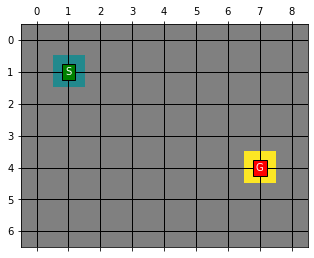

In [44]:
show_map(game_map)